#### Loading the Required Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings 
warnings.filterwarnings('ignore')

#### Loading the Dataset

In [2]:
# Reading the dataset and loading it to a dataframe.
def read_taxi_data(file) :
    df = pd.read_csv(file)
    return df

taxi_df= read_taxi_data('NYCTaxiFares.csv')

In [3]:
# Display the first 5 records.
taxi_df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [4]:
# Display the info about the dataframe.
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    120000 non-null  object 
 1   fare_amount        120000 non-null  float64
 2   fare_class         120000 non-null  int64  
 3   pickup_longitude   120000 non-null  float64
 4   pickup_latitude    120000 non-null  float64
 5   dropoff_longitude  120000 non-null  float64
 6   dropoff_latitude   120000 non-null  float64
 7   passenger_count    120000 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 7.3+ MB


Number of variables: 8 Number of records: 120000 Categorical types: 1 Numerical types: 2 Float Types: 5

In [5]:
# Number of rows and columns.
taxi_df.shape

(120000, 8)

In [6]:
# Some Statistical data.
taxi_df.describe().T

,count,mean,std,min,25%,50%,75%,max
fare_amount,120000.0,10.040326,7.500134,2.500000,5.700000,7.700000,11.30000,49.900000
fare_class,120000.0,0.333333,0.471406,0.000000,0.000000,0.000000,1.00000,1.000000
pickup_longitude,120000.0,-73.976626,0.031497,-74.465447,-73.992386,-73.982084,-73.96871,-73.311845
pickup_latitude,120000.0,40.751443,0.025821,40.121653,40.736594,40.753661,40.76802,40.981292
dropoff_longitude,120000.0,-73.974501,0.032419,-74.443323,-73.991478,-73.980411,-73.96550,-73.496140
dropoff_latitude,120000.0,40.751695,0.030279,40.164927,40.735914,40.754441,40.76888,40.993498
passenger_count,120000.0,1.347167,0.759263,1.000000,1.000000,1.000000,1.00000,5.000000


#### Data Pre-processing and Transformations

In [7]:
# To check the count of null values.
taxi_df.isnull().sum()

pickup_datetime      0
fare_amount          0
fare_class           0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [8]:
# To check for duplicates.
taxi_df.duplicated().sum()

0

In [9]:
# Calculation of distance between latitute and Longitude.
from math import radians, cos,sin, asin,sqrt

def distance(lon1, lon2, lat1 , lat2):
    
    
    lon1 =radians(lon1)
    lon2 =radians(lon2)
    lat1 =radians(lat1)
    lat2 =radians(lat2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    
    r = 6371
    return(round (c * r, 2))
    
    
d = []
for i in range(taxi_df.shape[0]):
    d.append(distance(taxi_df["pickup_latitude"][i],
                      taxi_df["dropoff_latitude"][i],
                      taxi_df["pickup_longitude"][i],
                      taxi_df["dropoff_longitude"][i]))

taxi_df["distance in kms"] = d

In [10]:
# Function to pre-process the data.

def process_taxi_data(df):
    # Converting pickup_datetime from Object type to TimeStamp type. 
    df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
    df["hour"] = df["pickup_datetime"].dt.hour
    df["month_day"] = df["pickup_datetime"].dt.day
    
    # Mapping days and Weekname.
    week_names = {0: "Sunday", 1: "Monday", 2: "Tuesday", 3: "Wednesday", 4: "Thursday", 5: "Friday", 6: "Saturday"}
    df["weekday_name"] = df["pickup_datetime"].dt.weekday.map(week_names)
    
    # Dropping Longitude and Latitude Features.
    df.drop(columns=["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude","pickup_datetime"], axis=1, inplace=True)
    
    # Reindex the dataframe columns.
    df=df.reindex(columns=['weekday_name','hour','month_day','fare_class','fare_amount','distance in kms','passenger_count'])
    
    return df

taxi_df=process_taxi_data(taxi_df)

In [11]:
taxi_df.dtypes

weekday_name        object
hour                 int64
month_day            int64
fare_class           int64
fare_amount        float64
distance in kms    float64
passenger_count      int64
dtype: object

In [12]:
taxi_df.head()

,weekday_name,hour,month_day,fare_class,fare_amount,distance in kms,passenger_count
0,Sunday,8,19,0,6.5,1.93,1
1,Friday,15,17,0,6.9,1.77,1
2,Friday,11,17,1,10.1,3.82,2
3,Saturday,21,11,0,8.9,2.16,1
4,Friday,2,17,1,19.7,9.46,1


#### Exploratory Data Analysis

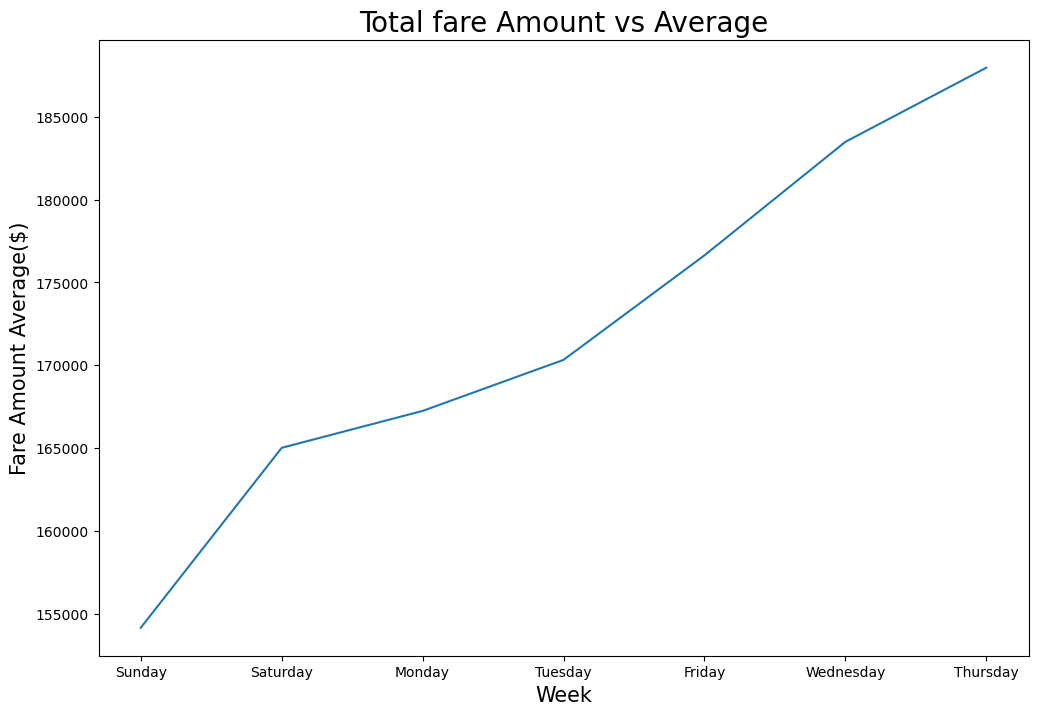

In [13]:
# Plotting graph of Fare vs Weekday name.

plt.figure(figsize = (12,8))
taxi_df.groupby("weekday_name")["fare_amount"].sum().sort_values().plot()

plt.xlabel("Week", fontsize=15)
plt.ylabel("Fare Amount Average($)", fontsize=15)
plt.title("Total fare Amount vs Average", fontsize=20)
plt.show()

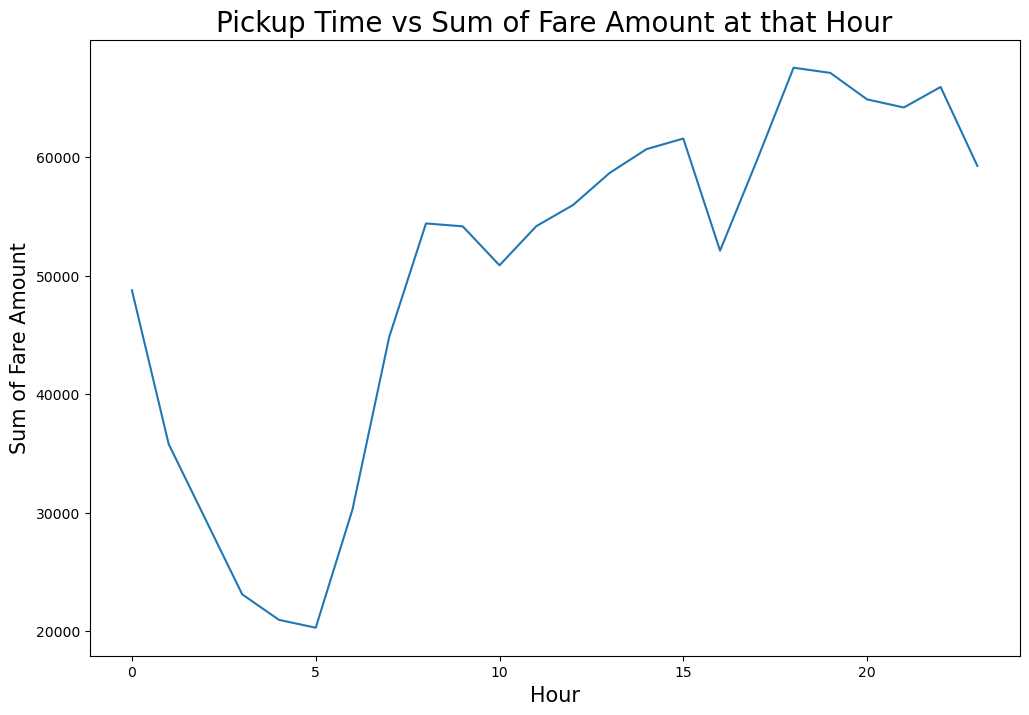

In [14]:
# Plotting graph of Fare vs Pickup time.

plt.figure(figsize = (12,8))

taxi_df.groupby("hour")["fare_amount"].sum().plot()
plt.title("Pickup Time vs Sum of Fare Amount at that Hour", fontsize=20)
plt.xlabel("Hour", fontsize=15)
plt.ylabel("Sum of Fare Amount", fontsize=15)
plt.show()

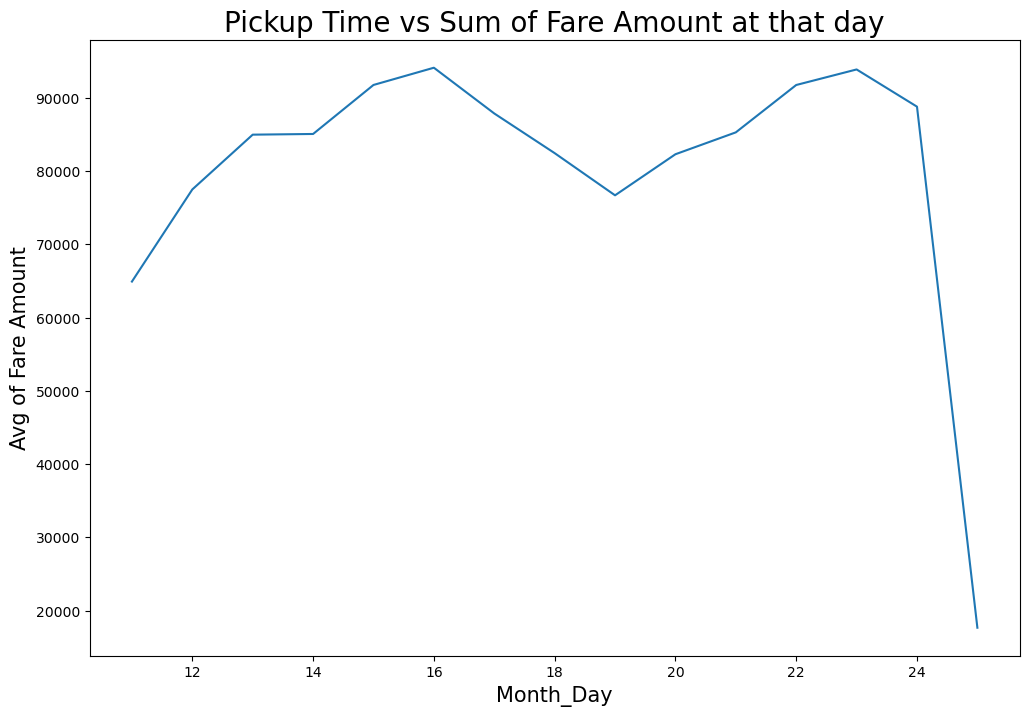

In [15]:
# Plotting graph of Fare vs Pickup day.
plt.figure(figsize = (12, 8))

taxi_df.groupby("month_day")["fare_amount"].sum().plot()
plt.title("Pickup Time vs Sum of Fare Amount at that day", fontsize=20)
plt.xlabel("Month_Day", fontsize=15)
plt.ylabel("Avg of Fare Amount", fontsize=15)
plt.show()

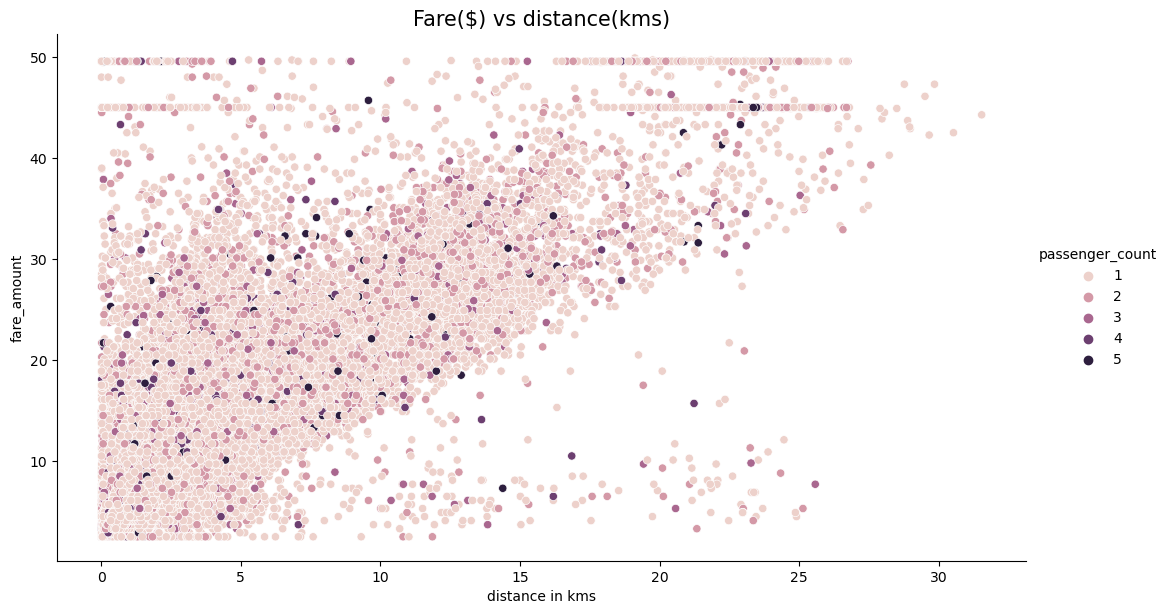

In [16]:
# Graph - Fare vs Distance.

sns.relplot(data = taxi_df, kind = "scatter",x = "distance in kms",y = "fare_amount",
            hue = "passenger_count",height=6 ,aspect = 1.75,)
plt.title("Fare($) vs distance(kms)" , fontsize=15)
plt.show()

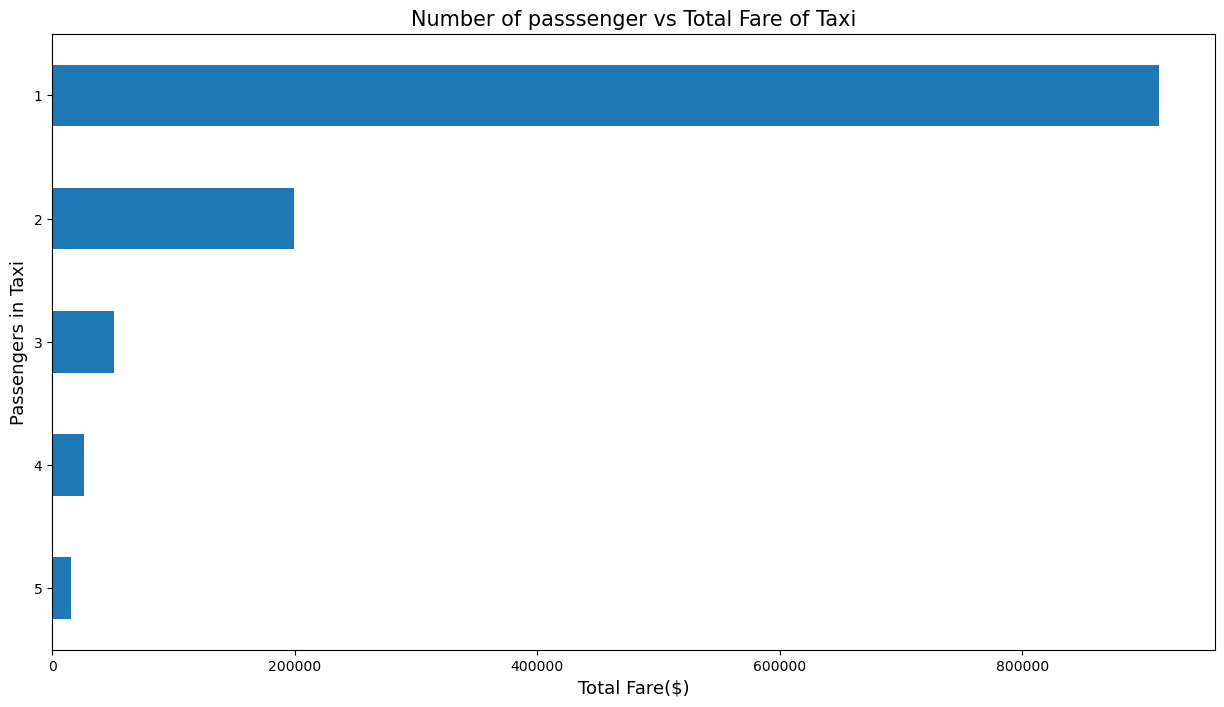

In [17]:
# Passenger Count Vs Fare.
plt.figure(figsize=(15,8))
taxi_df.groupby("passenger_count")["fare_amount"].sum().sort_values().plot.barh()
plt.xlabel("Total Fare($)",fontsize =13)
plt.ylabel("Passengers in Taxi", fontsize =13)
plt.title("Number of passsenger vs Total Fare of Taxi", fontsize = 15)
plt.show()

In [18]:
# Total passenger travelling in a Taxi for each fare class.
taxi_df.groupby(["fare_class","passenger_count"])[["passenger_count"]].sum()

passenger_count
fare_class passenger_count                 
0          1                          62591
           2                          23588
           3                           9426
           4                           6288
           5                           4505
1          1                          29940
           2                          13712
           3                           5196
           4                           3784
           5                           2630

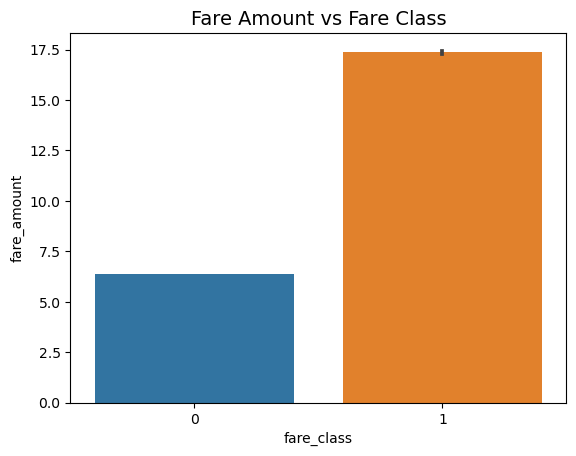

In [19]:
# Fare Amount vs Fare Class.
sns.barplot(data=taxi_df, x = "fare_class", y = "fare_amount")
plt.title("Fare Amount vs Fare Class", fontsize = 14)
plt.show()

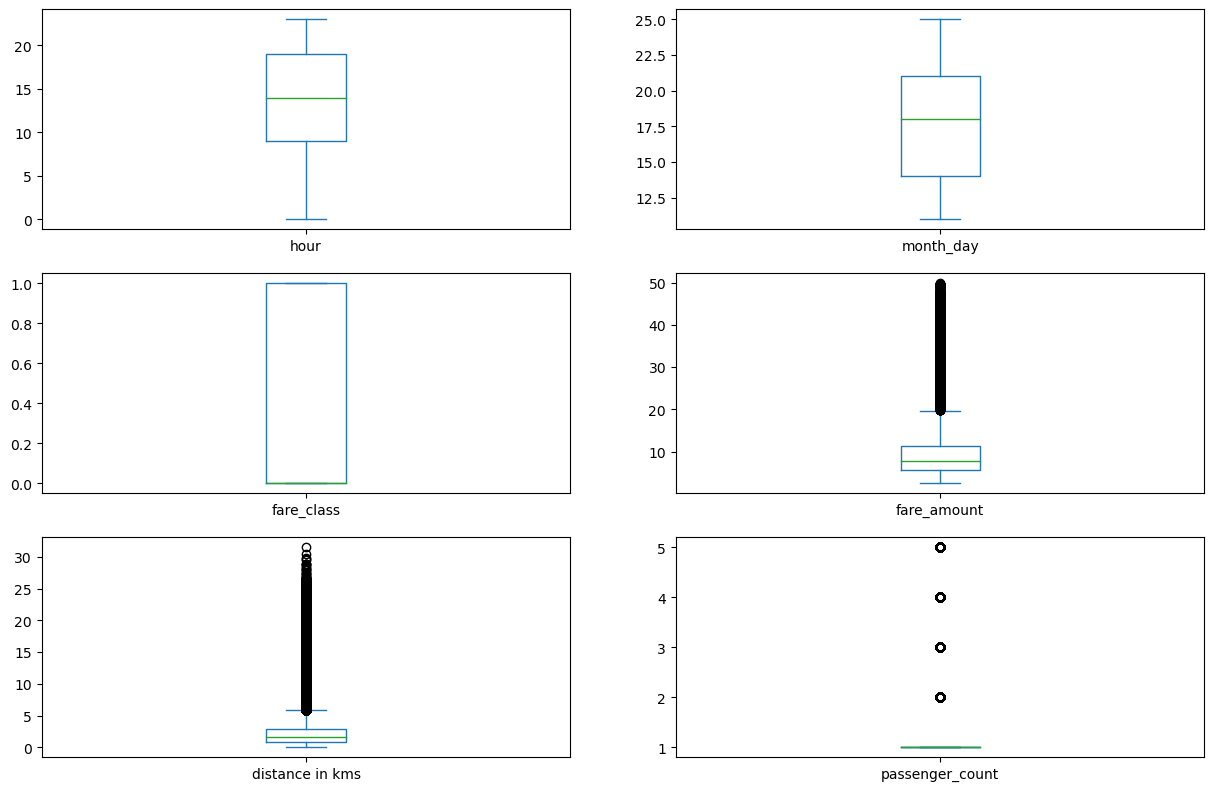

In [20]:
# Boxplot to check for outliers.
taxi_df.plot(kind = "box",subplots = True,layout = (6,2),figsize=(15,20)) 
plt.show()

In [21]:
def remove_outlier(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_whisker = q1 - 1.5 * iqr
    upper_whisker = q3 + 1.5 * iqr
    df[col] = np.clip(df[col], lower_whisker, upper_whisker)
    return df

def treat_outliers_all(df, col_list):
    for col in col_list:
        df = remove_outlier(df, col)
    return df

cols_to_remove_outliers = ['fare_amount', 'distance in kms']
taxi_df = treat_outliers_all(taxi_df, cols_to_remove_outliers)

#### Encoding

In [22]:
week_names_encode = {"Sunday": 1, "Saturday": 2, "Monday": 3, "Tuesday": 4, "Friday": 5, "Wednesday": 6, "Thursday": 7}
taxi_df["weekday_name"] = taxi_df["weekday_name"].map(week_names_encode)

In [23]:
taxi_df.describe()

,weekday_name,hour,month_day,fare_class,fare_amount,distance in kms,passenger_count
count,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000
mean,4.122000,13.246642,17.812433,0.333333,9.157815,2.120171,1.347167
std,1.989095,6.553962,4.023738,0.471406,4.661175,1.619549,0.759263
min,1.000000,0.000000,11.000000,0.000000,2.500000,0.000000,1.000000
25%,2.000000,9.000000,14.000000,0.000000,5.700000,0.900000,1.000000
50%,4.000000,14.000000,18.000000,0.000000,7.700000,1.600000,1.000000
75%,6.000000,19.000000,21.000000,1.000000,11.300000,2.880000,1.000000
max,7.000000,23.000000,25.000000,1.000000,19.700000,5.850000,5.000000


<AxesSubplot:>

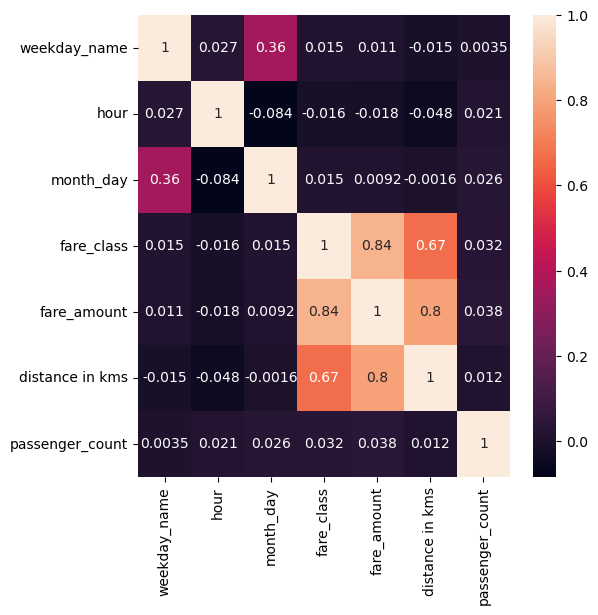

In [24]:
# Plotting heatmap with corelations to identify weakly corelated values.
plt.figure(figsize=(6,6))
sns.heatmap(taxi_df.corr(),annot=True)

In [25]:
taxi_df.to_csv('taxi_data_cleaned.csv', index=False)

#### Splitting Dataset for Training and Testing

In [26]:
features = taxi_df.drop(columns =['fare_amount'], axis = 1)
target = taxi_df['fare_amount']

In [27]:
x_train, x_test, y_train, y_test = train_test_split(features, target, shuffle = True, test_size = .30, random_state = 44)

In [28]:
print('Shape of training feature:', x_train.shape)
print('Shape of testing feature:', x_test.shape)
print('Shape of training label:', y_train.shape)
print('Shape of training label:', y_test.shape)

Shape of training feature: (84000, 6)
Shape of testing feature: (36000, 6)
Shape of training label: (84000,)
Shape of training label: (36000,)


#### Standardization

In [29]:
Scaler = StandardScaler()
Scaler.fit(x_train)

StandardScaler()

In [30]:
x_train = Scaler.transform(x_train)
x_test = Scaler.transform(x_test)

In [31]:
x_train

array([[ 1.4447926 , -0.49531807,  1.28487559, -0.70761823,  0.12764477,
         0.85477005],
       [-1.06824399,  1.02814601,  0.04480208,  1.4131914 ,  2.29852834,
        -0.45860104],
       [ 0.94218528, -0.19062526,  1.03686089, -0.70761823, -1.02563713,
         0.85477005],
       ...,
       [-1.06824399,  1.48518523,  0.04480208, -0.70761823, -1.1428155 ,
        -0.45860104],
       [-0.06302935,  0.72345319, -0.94725672,  1.4131914 ,  0.03513552,
         0.85477005],
       [-0.06302935, -0.9523573 ,  0.78884619, -0.70761823, -1.000968  ,
         0.85477005]])

#### Modeling

##### Random Forest

In [32]:
# Initialize the random forest regressor.
rf_model = RandomForestRegressor(n_estimators=200,max_depth=8,min_samples_split=3,random_state=44)

# Train the model on the preprocessed training data.
rf_model.fit(x_train, y_train)

# Use the trained model to make predictions on the preprocessed testing data.
rf_pred = rf_model.predict(x_test)

##### Model Evaluation

In [33]:
# Calculate the mean squared error (MSE).
mse = mean_squared_error(y_test, rf_pred)

# Calculate the root mean squared error (RMSE).
rmse = np.sqrt(mse)

# Calculate the mean absolute error (MAE).
mae = mean_absolute_error(y_test, rf_pred)

# Calculate the coefficient of determination (R^2).
r2 = r2_score(y_test, rf_pred)

# Print the evaluation metrics.
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 3.51
Root Mean Squared Error: 1.87
Mean Absolute Error: 1.41
R^2 Score: 0.84


In [34]:
# Create a dataframe to store the predictions.
rf1_results = pd.DataFrame({'Actual': y_test, 'Predicted': rf_pred})

# Save the predictions to a CSV file.
rf1_results.to_csv('rf_predictions_taxi_imp1.csv', index=False)

##### Random Forest from another library: XGBoost

In [35]:
# Initialize the XGBoost regressor.
xgb_model = XGBRegressor(
    learning_rate=0.01,
    max_depth=6,
    n_estimators=500,
    colsample_bytree=0.9,
    subsample=0.8,
    reg_alpha=0.05,
    reg_lambda=0.05,
    random_state=44
)

# Train the model on the preprocessed training data.
xgb_model.fit(x_train, y_train)

# Use the trained model to make predictions on the preprocessed testing data.
xgb_pred = xgb_model.predict(x_test)

##### Model Evaluation

In [36]:
# Calculate the mean squared error (MSE).
mse = mean_squared_error(y_test, xgb_pred)

# Calculate the root mean squared error (RMSE).
rmse = np.sqrt(mse)

# Calculate the mean absolute error (MAE).
mae = mean_absolute_error(y_test, xgb_pred)

# Calculate the coefficient of determination (R^2).
r2 = r2_score(y_test, xgb_pred)

# Print the evaluation metrics.
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 3.51
Root Mean Squared Error: 1.87
Mean Absolute Error: 1.41
R^2 Score: 0.84


In [37]:
# Create a dataframe to store the predictions.
rf2_results = pd.DataFrame({'Actual': y_test, 'Predicted': xgb_pred})

# Save the predictions to a CSV file.
rf2_results.to_csv('rf_predictions_taxi_imp2.csv', index=False)

##### Linear Regression

In [38]:
# Initialize the linear regression model.
lr_model = LinearRegression()

# Train the model on the preprocessed training data.
lr_model.fit(x_train, y_train)

# Use the trained model to make predictions on the preprocessed testing data.
lr_pred = lr_model.predict(x_test)

##### Model Evaluation

In [39]:
# Calculate the mean squared error (MSE).
mse = mean_squared_error(y_test, lr_pred)

# Calculate the root mean squared error (RMSE).
rmse = np.sqrt(mse)

# Calculate the mean absolute error (MAE).
mae = mean_absolute_error(y_test, lr_pred)

# Calculate the coefficient of determination (R^2).
r2 = r2_score(y_test, lr_pred)

# Print the evaluation metrics.
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 4.17
Root Mean Squared Error: 2.04
Mean Absolute Error: 1.56
R^2 Score: 0.81


In [40]:
# Create a dataframe to store the predictions
lr1_results = pd.DataFrame({'Actual': y_test, 'Predicted': lr_pred})

# Save the predictions to a CSV file
lr1_results.to_csv('lr_predictions_taxi_imp1.csv', index=False)

##### Linear Regression from another Library

In [41]:
# Add a column of ones to the feature matrix to represent the intercept term.
ones_column = np.ones((x_train.shape[0], 1))
X_train = np.hstack((ones_column, x_train))

# Compute the least-squares solution for the training data.
w = np.linalg.lstsq(X_train, y_train, rcond=None)[0]

# Add a column of ones to the test feature matrix to represent the intercept term.
ones_column = np.ones((x_test.shape[0], 1))
X_test = np.hstack((ones_column, x_test))

# Make predictions on the test data.
lr_pred = np.dot(X_test, w)

##### Model Evaluation

In [42]:
# Calculate the mean squared error (MSE).
mse = np.mean((y_test - lr_pred) ** 2)

# Calculate the root mean squared error (RMSE).
rmse = np.sqrt(mse)

# Calculate the mean absolute error (MAE).
mae = np.mean(np.abs(y_test - lr_pred))

# Calculate the coefficient of determination (R^2).
ss_res = np.sum((y_test - lr_pred) ** 2)
ss_tot = np.sum((y_test - np.mean(y_test)) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Print the evaluation metrics.
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 4.17
Root Mean Squared Error: 2.04
Mean Absolute Error: 1.56
R^2 Score: 0.81


In [43]:
# Create a dataframe to store the predictions.
lr2_results = pd.DataFrame({'Actual': y_test, 'Predicted': lr_pred})

# Save the predictions to a CSV file.
lr2_results.to_csv('lr_predictions_taxi_imp2.csv', index=False)